# Raton denoising

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(40)

In [2]:
from tramp.models import DAGModel, MultiLayerModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur2DChannel, GradientChannel, GaussianChannel
from tramp.priors import (
    GaussBernouilliPrior, BinaryPrior, GaussianPrior,
    MAP_LaplacePrior, MAP_L21NormPrior
)
from tramp.algos import (
    ExpectationPropagation, StateEvolution, 
    TrackEvolution, EarlyStopping, JoinCallback, 
    NoisyInit, ConstantInit
)

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [4]:
def plot_data():
    fig, axs = plt.subplots(1,4,figsize=(12,3), sharey=True)
    axs[0].imshow(x, cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(x_grad[0], cmap="gray")
    axs[1].set(title=r"$(\nabla x)_0$")
    axs[2].imshow(x_grad[1], cmap="gray")
    axs[2].set(title=r"$(\nabla x)_1$")
    axs[3].imshow(y, cmap="gray")
    axs[3].set(title=r"$y$")
    fig.tight_layout()
    
def plot_histos():
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
    axs[0].hist(
        x.ravel(), bins=251, 
        normed=True, histtype='stepfilled', alpha=0.2
    )
    fitted = laplace(loc=0, scale=scale_grad)
    axs[0].set(title=r"$x$")
    axs[1].hist(
        x_grad_ravel[nonzero], bins=100, log="y", 
        normed=True, histtype='stepfilled', alpha=0.2
    )
    x_histo = np.linspace(-2, 2, 100)
    axs[1].plot(x_histo, fitted.pdf(x_histo))
    axs[1].set(title=r"$\nabla x$")
    fig.tight_layout()

def plot_prediction(r_pred):
    fig, axs = plt.subplots(1,3,figsize=(9, 3), sharey=True)
    axs[0].imshow(r_pred["x"], cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(r_pred["x'"][0], cmap="gray")
    axs[1].set(title=r"$(\nabla x)_0$")
    axs[2].imshow(r_pred["x'"][1], cmap="gray")
    axs[2].set(title=r"$(\nabla x)_1$")
    fig.tight_layout()
    
def compare_prediction(r_pred, u1=20):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=False)
    axs[0].plot(x[:,u1], label="true")
    axs[0].plot(r_pred["x"][:,u1], label="pred")
    axs[0].plot(y[:,u1], ".", label="y", color="gray", alpha=0.2)
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_grad[0,:,u1], label="true")
    axs[1].plot(r_pred["x'"][0,:,u1], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$(\nabla x)_0$")
    fig.tight_layout()
    
def run_model(model, initializer=None):
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback, initializer=initializer)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)
    compare_prediction(r_pred, u1=20)

## Image

x_mean=9.72e-08 x_var=1.00e+00
rho_grad=0.90 var_grad=0.0653405322822262
loc_grad=-9.30e-11 scale_grad=0.17


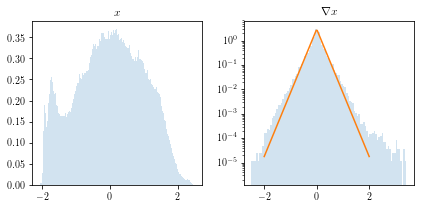

In [5]:
from scipy.stats import laplace
from scipy.misc import face
raton = face(gray=True).astype(np.float32)

# signal 
s_blur = 10
x = (raton - raton.mean())/raton.std()
print(f"x_mean={x.mean():.2e} x_var={x.var():.2e}")
x_shape = np.shape(x)
# gradient
grad = GradientChannel(shape=x_shape)
x_grad = grad.convolve(x)
x_grad_ravel = x_grad.ravel()
nonzero = np.abs(x_grad_ravel) > 1e-3
rho_grad = nonzero.mean()
var_grad = x_grad_ravel[nonzero].var()
print(f"rho_grad={rho_grad:.2f} var_grad={var_grad}")
from scipy.stats import laplace
loc_grad, scale_grad = laplace.fit(x_grad_ravel[nonzero].ravel())
fitted = laplace(loc=0, scale=scale_grad)
print(f"loc_grad={loc_grad:.2e} scale_grad={scale_grad:.2f}")
# noise
var_noise = 0.5
y = x + np.sqrt(var_noise)*np.random.standard_normal(x_shape)

plot_histos()

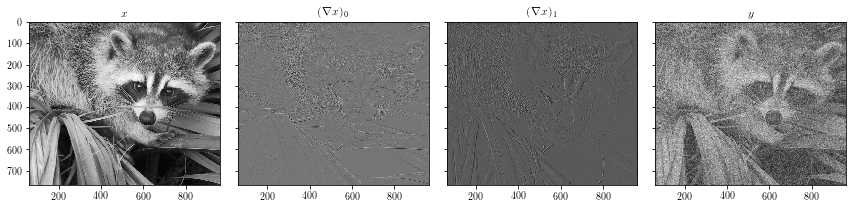

In [6]:
plot_data()

## Sparse gradient denoising

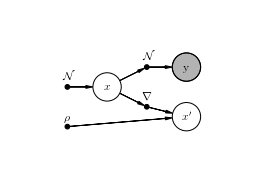

In [7]:
# sparse grad denoiser
grad_shape = (2,) + x_shape

sparse_grad = (
    GaussianPrior(size=x_shape) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            GaussBernouilliPrior(size=grad_shape, var=2, rho=rho_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
sparse_grad = DAGModel(sparse_grad)
sparse_grad.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=25 iterations


n_iter=25
v_pred={'x': 0.14677116591792178, "x'": 0.24258799641780238}
x_mse=0.17708535307218864


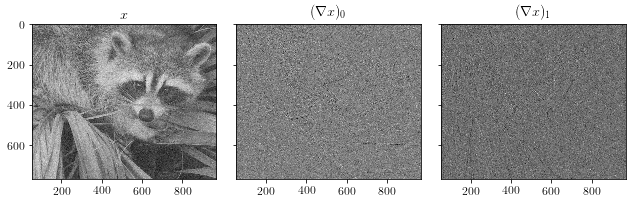

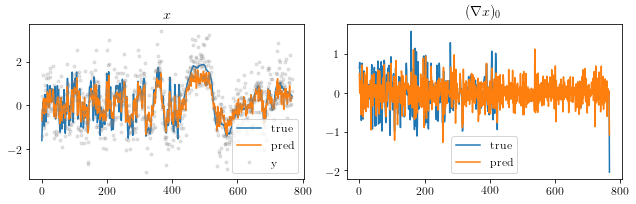

In [8]:
run_model(sparse_grad)

## TV denoising


<div class="alert alert-warning">
We need to set initial conditions a=b=1. For a=b=0 ExpectationPropagation diverges.
</div>

/Users/antoinebaker/Documents/projects/ml_physics/tramp/priors/map_L21_norm_prior.py:26: UserWarning: MAP_L21NormPrior.sample not implemented return zero array as a placeholder
  "MAP_L21NormPrior.sample not implemented "
/Users/antoinebaker/Documents/projects/ml_physics/tramp/priors/map_L21_norm_prior.py:36: UserWarning: MAP_L21NormPrior.second_moment not implemented return 1 as a placeholder
  "MAP_L21NormPrior.second_moment not implemented "


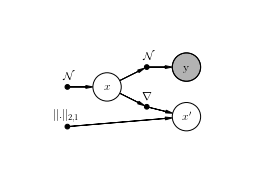

In [9]:
# TV denoiser
grad_shape = (2,) + x_shape

tv_denoiser = (
    GaussianPrior(size=x_shape) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            MAP_L21NormPrior(size=grad_shape, scale=1)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
tv_denoiser = DAGModel(tv_denoiser)
tv_denoiser.daft()

INFO:root:init message dag with ConstantInit(a=1,b=1)
INFO:root:new_v=0.041772596429985286>old_v=0.041755430883779275 for SIMOVariable(n_prev=1,n_next=2,id=x)
INFO:root:terminated after n_iter=16 iterations


n_iter=16
v_pred={'x': 0.041755430883779275, "x'": 0.053545559271235089}
x_mse=0.16609204321576682


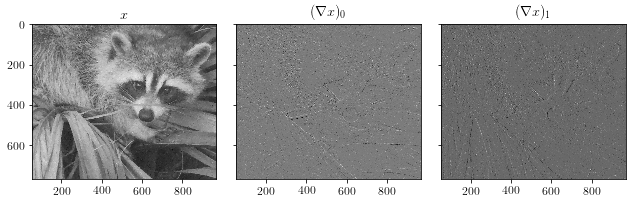

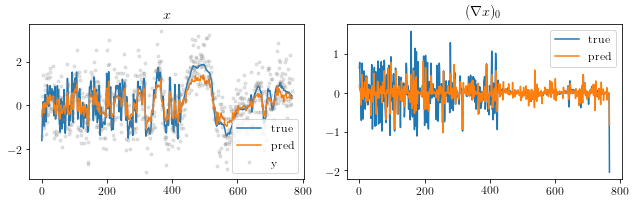

In [10]:
run_model(tv_denoiser, initializer=ConstantInit(a=1,b=1))